In [119]:
from pystac import ItemCollection
from pystac_client import Client

#bbox = [29.242740, -0.807347, 29.629208, -0.591585]
bbox = [29.296298, -1.582263, 29.769293, -1.197520]

max_cloud_cover = 50
stac_date_format = '%Y-%m-%dT%H:%M:%SZ'
stac_date_string = "2022-01-01T00:00:00/2022-03-01T00:00:00"

client = Client.open("https://earth-search.aws.element84.com/v0")

search = client.search(
    bbox=bbox,
    collections=['sentinel-s2-l2a-cogs'], 
    datetime=stac_date_string,
    sortby='-properties.datetime',
    query={
        "eo:cloud_cover":{
            "lt": str(max_cloud_cover)
        },
    },
)

print(f"{search.matched()} items found")

# limit number of images per Sentinel grid square
limit = 4
items, items_count = [], {}
for item in list(search.items()):
    square = item.properties['sentinel:grid_square']
    count = items_count.get(square, 0)
    if count < limit:
        items.append(item)
        items_count[square] = count + 1

print(f'\t{items_count}')

collection = ItemCollection(items=items)

dst_dir = "./data/cloudmask"

collection.save_object(f'{dst_dir}/collection.json')


14 items found
	{'QU': 4, 'RU': 4}


In [51]:
%%bash
# S2B_35MRU_20200217_0_L2A, S2B_35MQU_20200217_0_L2A
#gdalinfo ./data/cloudmask/S2B_35MQU_20200217_0_L2A/stack_masked_merged.tif

In [120]:
%reload_ext autoreload
%autoreload 2

from osgeo import gdal

from common.constants import NODATA_FLOAT32, S2_BANDS_TIFF_ORDER
import common.utilities.download as download
import common.utilities.imagery as imagery


blank_float32_path = f'{dst_dir}/blank_float32.tif'
imagery.create_blank_tif(bbox, dst_path=blank_float32_path, dtype=gdal.GDT_Float32, nodata=NODATA_FLOAT32)

original_scenes = download.download_collection(collection, bbox, S2_BANDS_TIFF_ORDER, dst_dir)


	downloading... S2B_35MQU_20220226_0_L2A
	downloading... S2A_35MQU_20220221_0_L2A
	downloading... S2A_35MRU_20220221_0_L2A
	downloading... S2B_35MQU_20220216_0_L2A
	downloading... S2B_35MRU_20220216_0_L2A
	downloading... S2A_35MQU_20220211_0_L2A
	downloading... S2B_35MRU_20220206_0_L2A
	downloading... S2B_35MRU_20220127_0_L2A


In [122]:
%reload_ext autoreload
%autoreload 2

import common.utilities.imagery as imagery
import common.utilities.masking as masking


processed_scenes = {}
for scene in original_scenes:
    print(f'\tmasking and merging... {scene}')

    scene_dir = f'{dst_dir}/{scene}'        
    meta = original_scenes[scene]['meta']

    stack_original_tif_path = original_scenes[scene]['stack_original_tif_path']  # 1. original and normalized
    stack_masked_tif_path = f'{scene_dir}/stack_masked.tif'                      # 2. masked with original shape
    stack_masked_merged_tif_path = f'{scene_dir}/stack_masked_merged.tif'        # 3. merged with blank
    
    model_path = './best_resnet18_dice_virunga_cloud_model.pth'
    if not masking.apply_nn_cloud_mask(stack_original_tif_path, meta, stack_masked_tif_path, model_path):
        continue
    
    # I think SCL masking is broken, need to update thresholds
    # masking.apply_scl_cloud_mask(stack_original_tif_path, meta, stack_masked_tif_path)
    
    imagery.merge_stack_with_blank(stack_masked_tif_path, blank_float32_path, bbox, merged_path=stack_masked_merged_tif_path)
    processed_scenes[scene] = stack_masked_merged_tif_path
    
    

	masking and merging... S2B_35MQU_20220226_0_L2A
skipping ./data/cloudmask/S2B_35MQU_20220226_0_L2A/stack_original.tif, 100.0% clouds
	masking and merging... S2A_35MQU_20220221_0_L2A
skipping ./data/cloudmask/S2A_35MQU_20220221_0_L2A/stack_original.tif, 90.0% clouds
	masking and merging... S2A_35MRU_20220221_0_L2A
skipping ./data/cloudmask/S2A_35MRU_20220221_0_L2A/stack_original.tif, 95.0% clouds
	masking and merging... S2B_35MQU_20220216_0_L2A
	masking and merging... S2B_35MRU_20220216_0_L2A
	masking and merging... S2A_35MQU_20220211_0_L2A
	masking and merging... S2B_35MRU_20220206_0_L2A
	masking and merging... S2B_35MRU_20220127_0_L2A
skipping ./data/cloudmask/S2B_35MRU_20220127_0_L2A/stack_original.tif, 95.0% clouds


In [123]:
%reload_ext autoreload
%autoreload 2

import common.utilities.imagery as imagery

composite_path = f'{dst_dir}/composite.tif'

stacks_processed_tif_paths = list(processed_scenes.values())    
imagery.create_composite_from_paths(stacks_processed_tif_paths, composite_path)


## Update this for presentation plots

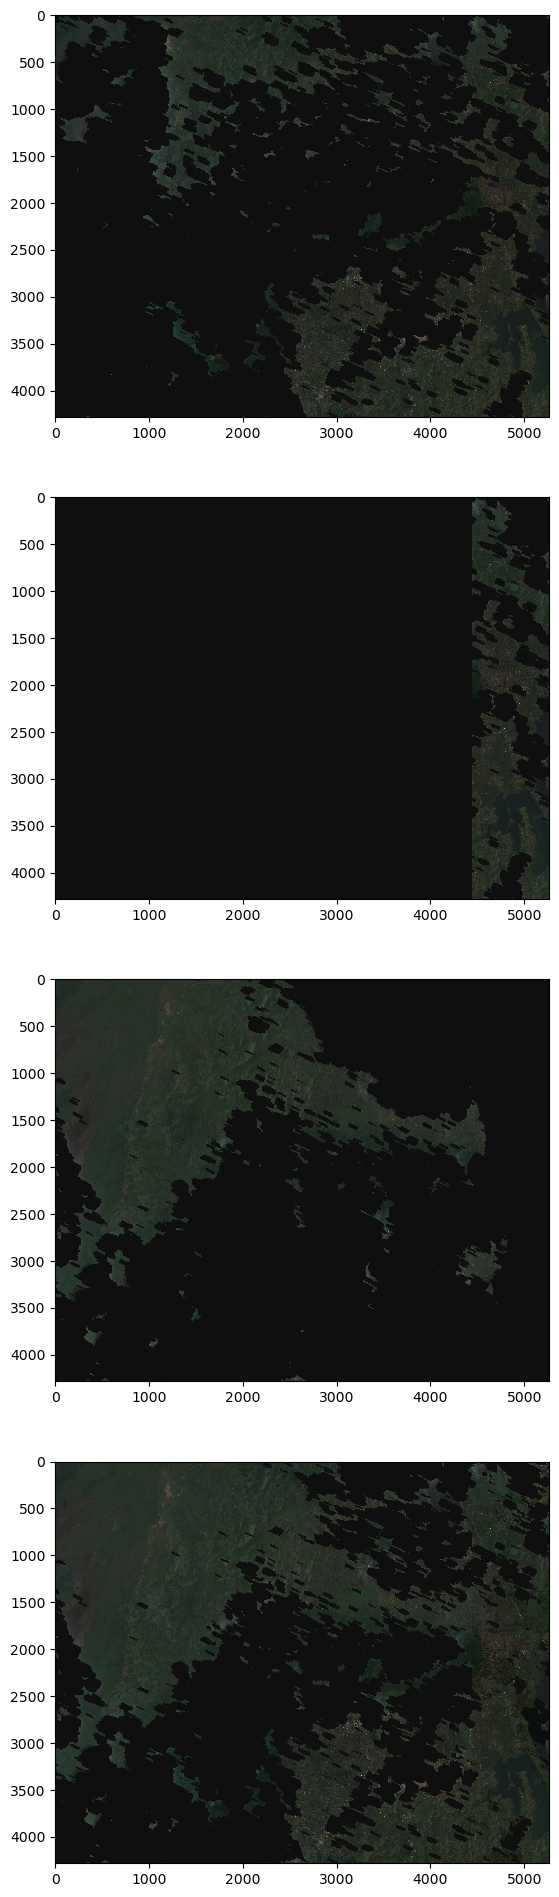

In [126]:
import matplotlib.pyplot as plt
import rasterio

from common.utilities.visualization import plot_bands

#tif_path1 = "./data/cloudmask/S2A_35MQU_20200212_0_L2A/stack_original.tif"
#tif_path1 = "./data/cloudmask/S2A_35MQV_20200123_0_L2A/stack_original.tif"
#tif_path1 = "./data/cloudmask/S2A_35MQV_20220211_0_L2A/stack_masked_merged.tif"
tif_path1 = "./data/cloudmask/S2B_35MQU_20220216_0_L2A/stack_masked_merged.tif"

#tif_path2 = "./data/cloudmask/S2B_35MQU_20200217_0_L2A/stack_original.tif"
# tif_path2 = "./data/cloudmask/S2A_35MQV_20200212_0_L2A/stack_original.tif"
#tif_path2 = "./data/cloudmask/S2B_35MQV_20220206_0_L2A/stack_masked_merged.tif"
tif_path2 = "./data/cloudmask/S2B_35MRU_20220216_0_L2A/stack_masked_merged.tif"

#tif_path3 = "./data/cloudmask/S2B_35MQU_20200207_0_L2A/stack_original.tif"
# tif_path3 = "./data/cloudmask/S2B_35MQV_20200207_0_L2A/stack_original.tif"
#tif_path3 = "./data/cloudmask/S2B_35MQV_20220216_0_L2A/stack_masked_merged.tif"
tif_path3 = "./data/cloudmask/S2A_35MQU_20220211_0_L2A/stack_masked_merged.tif"

tif_path4 = "./data/cloudmask/composite.tif"
# tif_path4 = "./data/cloudmask/S2B_35MQV_20220226_0_L2A/stack_masked_merged.tif"

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(24, 24))

with rasterio.open(tif_path1) as src:
    data1 = src.read(masked=True)

with rasterio.open(tif_path2) as src:
    data2 = src.read(masked=True)

with rasterio.open(tif_path3) as src:
    data3 = src.read(masked=True)
    
with rasterio.open(tif_path4) as src:
    data4 = src.read(masked=True)

plot_bands(data1, ax=ax1, bands=[2, 1, 0], transpose=True)
plot_bands(data2, ax=ax2, bands=[2, 1, 0], transpose=True)
plot_bands(data3, ax=ax3, bands=[2, 1, 0], transpose=True)
plot_bands(data4, ax=ax4, bands=[2, 1, 0], transpose=True)



-9999.0 -9999.0 18528.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-9999.0 -9999.0 -8437.916 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cloud masking with..../best_resnet18_dice_virunga_cloud_model.pth
./data/cloudmask/S2B_35MRU_20200217_0_L2A/B08.tif
(5, 4283, 5265)


RuntimeError: No active exception to reraise

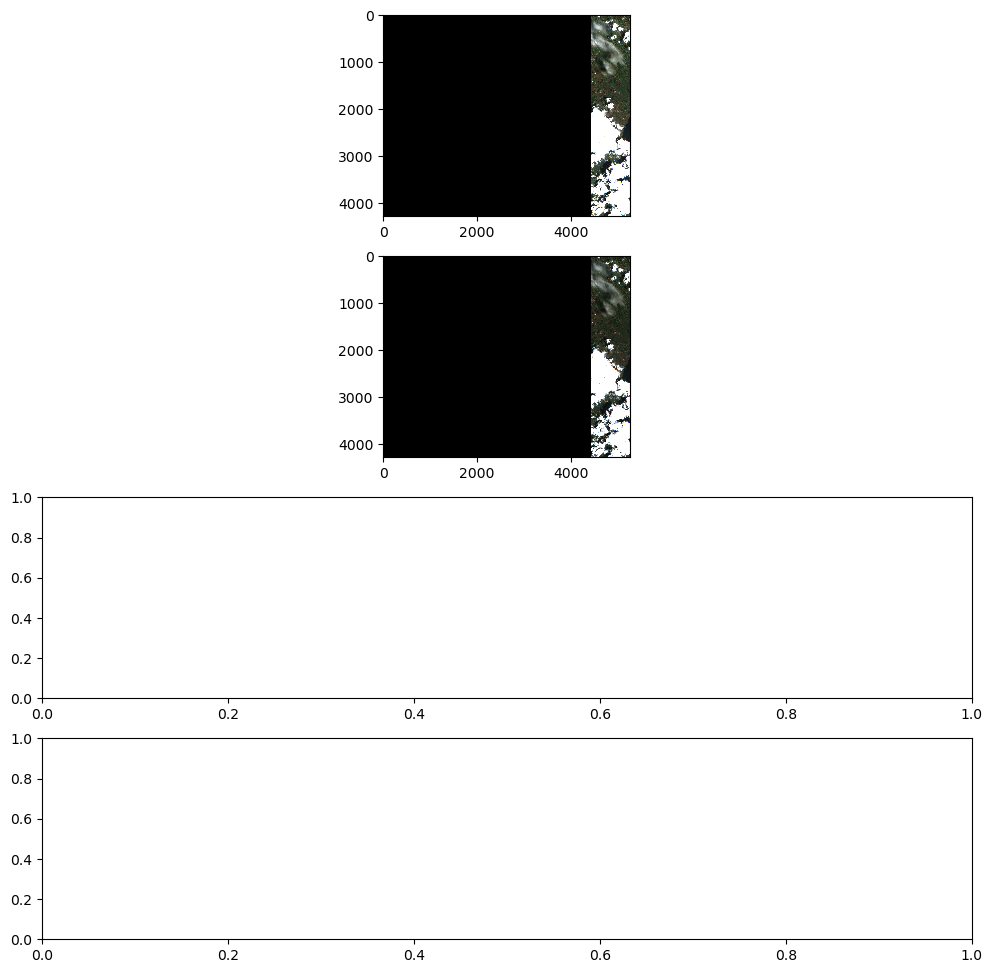

In [25]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import rasterio

import common.utilities.imagery as imagery
import common.utilities.masking as masking
import common.utilities.visualization as visualization

scene = "S2B_35MRU_20200217_0_L2A" # S2A_35MQV_20200212_0_L2A, S2B_35MQV_20200217_0_L2A, S2A_35MQU_20200212_0_L2A, S2B_35MRU_20200217_0_L2A
stack_tif_path = f"./data/cloudmask/{scene}/stack.tif"
norm_tif_path = f"./data/cloudmask/{scene}/stack_norm.tif"
nn_masked_tif_path = f"./data/cloudmask/{scene}/stack_masked_nn.tif"
nir_tif_path = f'./data/cloudmask/{scene}/B08.tif'


model_path = "./best_resnet18_dice_virunga_cloud_model.pth"

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))

with rasterio.open(stack_tif_path) as src:
    data = src.read()
    print(np.min(data), np.median(data), np.max(data))
    visualization.plot_bands(data / 3000, bands=[2, 1, 0], ax=ax1, transpose=True)
    
imagery.normalize_tif(stack_tif_path, dst_path=norm_tif_path)

with rasterio.open(norm_tif_path) as src:
    data = src.read()
    print(np.min(data), np.median(data), np.mean(data), np.max(data))
    visualization.plot_bands(data, bands=[2, 1, 0], ax=ax2, transpose=True)

meta = {'AZIMUTH_ANGLE': 114.781184935592, 'ZENITH_ANGLE': 28.8703779324312}
masking.apply_nn_cloud_mask(norm_tif_path, meta, nn_masked_tif_path, model_path)

with rasterio.open(nn_masked_tif_path) as src:
    data = src.read(masked=True)
    print(np.min(data), np.ma.median(data), np.mean(data), np.max(data))
    visualization.plot_bands(data, bands=3, ax=ax3, transpose=True, cmap='viridis')
    
with rasterio.open(nir_tif_path) as src:
    ax4.imshow(src.read(1))


./data/cloudmask/S2B_35MQV_20200217_0_L2A/stack_masked.tif
./data/cloudmask/S2B_35MQV_20200217_0_L2A/stack_masked_nn.tif
1 2.0 7372.0
2 0.0 1.0 0.04446978494524956


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 0.0 1.0 0.4620141386985779
./data/cloudmask/S2A_35MQV_20200212_0_L2A/stack_masked.tif
./data/cloudmask/S2A_35MQV_20200212_0_L2A/stack_masked_nn.tif
1 2.0 21136.0
2 0.0 0.91215914 0.0387735441327095


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 0.0 0.74355197 0.036419935524463654


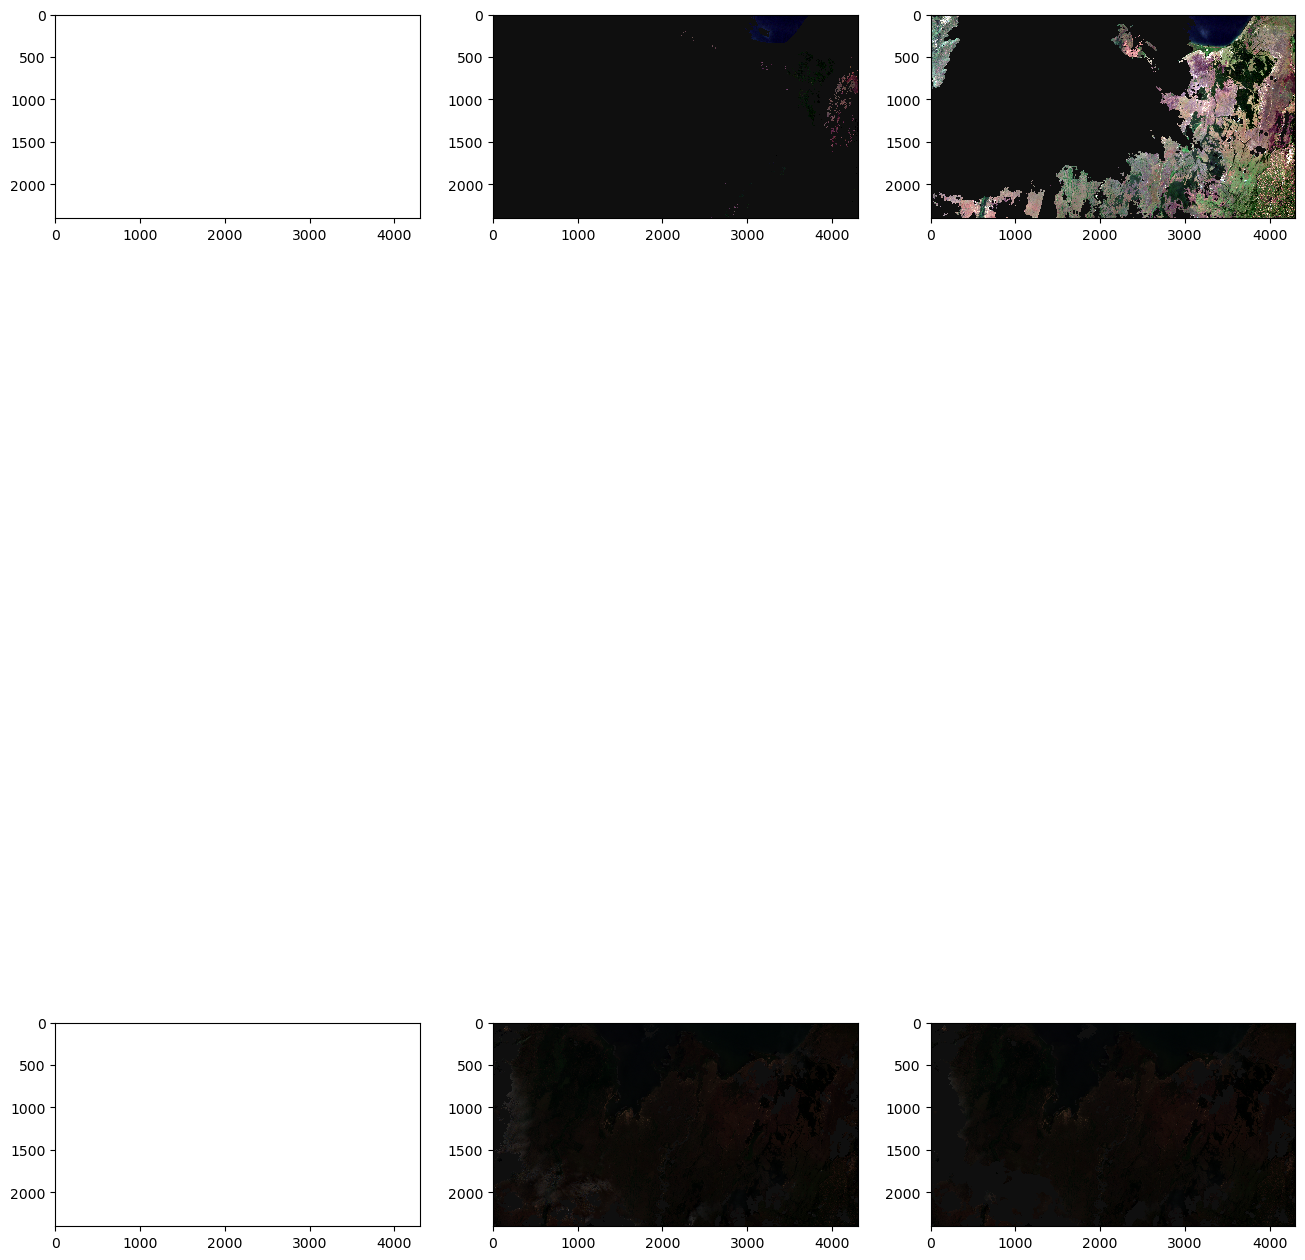

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio

from common.utilities.visualization import plot_bands


count = len(masked_scenes.values())
fig, rows = plt.subplots(count, 3, figsize=(16, 24))

for i, scene in enumerate(masked_scenes):
    
    row = rows[i]
    
    stack_tif_path = masked_scenes[scene]['stack_tif_path']
    masked_tif_path = masked_scenes[scene]['masked_tif_path']
    nn_masked_tif_path = masked_scenes[scene]['nn_masked_tif_path']
    
    print(masked_tif_path)
    print(nn_masked_tif_path)

    with rasterio.open(stack_tif_path) as src:
        stack_tif_data = src.read(masked=True)
        
    with rasterio.open(masked_tif_path) as src:
        masked_tif_data = src.read(masked=True)
   
    with rasterio.open(nn_masked_tif_path) as src:
        masked_nn_tif_data = src.read(masked=True)
        
    print(1, np.min(stack_tif_data), np.max(stack_tif_data))
    print(2, np.min(masked_tif_data), np.max(masked_tif_data), np.ma.median(masked_tif_data))
    print(3, np.min(masked_nn_tif_data), np.max(masked_nn_tif_data), np.ma.median(masked_nn_tif_data))

    plot_bands(stack_tif_data, bands=[2, 1, 0], ax=row[0], transpose=True)
    plot_bands(masked_tif_data, bands=[2, 1, 0], ax=row[1], transpose=True)
    plot_bands(masked_nn_tif_data, bands=[2, 1, 0], ax=row[2], transpose=True)
    
plt.show()

In [131]:
%%bash

gdalinfo -stats ./data/cloudmask/S2B_35MQV_20200217_0_L2A/stack.tif

Driver: GTiff/GeoTIFF
Files: ./data/cloudmask/S2B_35MQV_20200217_0_L2A/stack.tif
Size is 4302, 2402
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (29.242740000000001,-0.591585000000000)
Pixel Size = (0.000089834495583,-0.000089825978351)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (  29.2427400,  -0.5915850) ( 29d14'33.86"E,  0d35'29.71"S)
Lower Left  (  29.2427400,  -0.8073470) ( 29d14'33.86"E,  0d48'26.45

In [4]:
all_band_paths = list(composites.values())
rgb_band_paths = [composites['B04'], composites['B03'], composites['B02']]

all_uint16_vrt_path = f'./testingCloudMask/all_uint16.vrt'
create_vrt(all_band_paths, all_uint16_vrt_path)

all_byte_vrt_path = f'./testingCloudMask/all_byte.vrt'
create_byte_vrt(all_uint16_vrt_path, all_byte_vrt_path)

all_byte_cog_path = f'./testingCloudMask/all_byte_cog.tif'
create_tif(all_byte_vrt_path, all_byte_cog_path, isCog=True)

rgb_uint16_vrt_path = f'./testingCloudMask/rgb_uint16.vrt'
create_vrt(rgb_band_paths, rgb_uint16_vrt_path)

rgb_byte_vrt_path = f'./testingCloudMask/rgb_byte.vrt'
create_byte_vrt(rgb_uint16_vrt_path, rgb_byte_vrt_path)

rgb_byte_tif_path = f'./testingCloudMask/rgb_byte_cog.tif'
create_tif(rgb_byte_vrt_path, rgb_byte_tif_path, isCog=True)


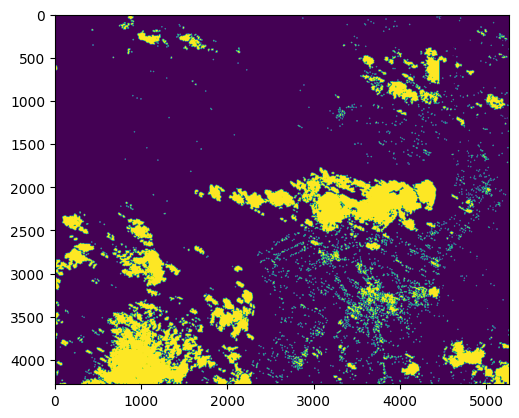

In [24]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

b08_composite = "./testingCloudMask/B08_composite.tif"
data = rasterio.open(b08_composite).read(1, masked=True)

mask = data.mask
plt.imshow(mask)
plt.show()

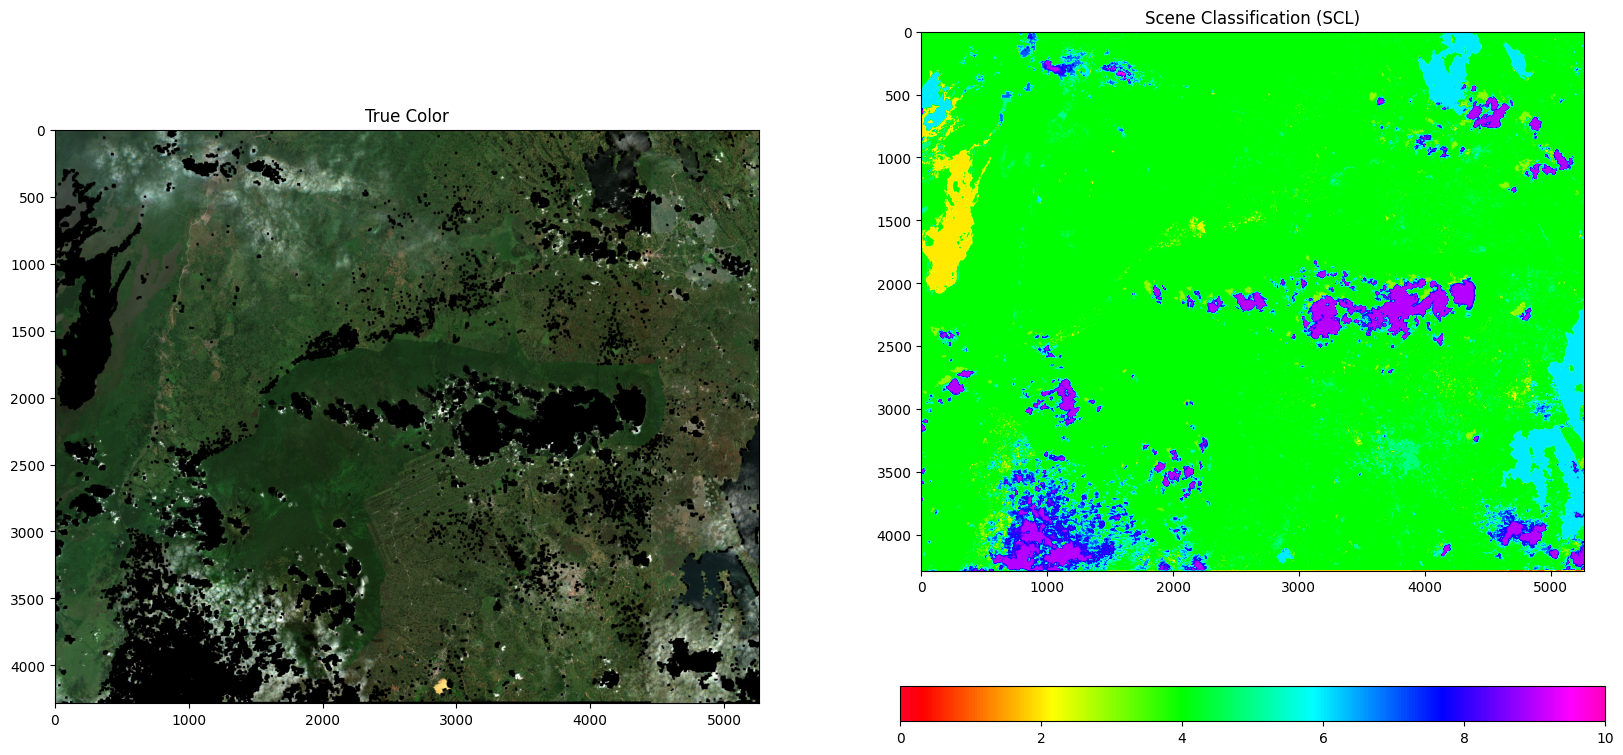

In [88]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

scl_path = "./testing2/S2B_35MQU_20200207_0_L2A//SCL.tif"


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))


show(rasterio.open(rgb_byte_tif_path).read(), ax=ax1)
ax1.set_title("True Color")

show(rasterio.open(scl_path).read(1), ax=ax2, cmap='gist_rainbow')
scl_im = ax2.get_images()[0]
plt.colorbar(scl_im, ax=ax2, orientation="horizontal")
ax2.set_title("Scene Classification (SCL)")


plt.show()

In [172]:
import numpy as np
from scipy.ndimage import distance_transform_edt, shift


cloud_mask = np.array([
    [False, False, False, False, False],
    [False, True, True, False, False],
    [False, False, True,  False, False],
    [False, False, False, False, False],
    [False, False, False, False, False],
])


azimuth = 315
zenith = 20
cloud_heights = np.arange(400, 1200, 200) 
scale = 100

azimuth_rad = np.deg2rad(azimuth)
zenith_rad = np.deg2rad(zenith)

def get_potential_shadow(cloud_height):

    shadow_vector = round(np.tan(zenith_rad) * cloud_height)

    x_shift = round(np.cos(azimuth_rad) * shadow_vector / scale)
    y_shift = round(np.sin(azimuth_rad) * shadow_vector / scale)

    print('x_shift:', x_shift, ', y_shift:', y_shift)

    # TODO: check if negatives working... I don't think they are...

    shadows = np.roll(cloud_mask, y_shift, axis=0)
    shadows = np.roll(shadows, x_shift, axis=1)
    
    if x_shift > 0:
        shadows[:, :x_shift] = False
    elif x_shift < 0:
        shadows[:, x_shift:] = False

    if y_shift > 0:
        shadows[:y_shift, :] = False
    elif y_shift < 0:
        shadows[y_shift:, :] = False
    
    print(shadows)
    
    return shadows




shadow_vector: 146
x_shift: 10 , y_shift: -10


In [10]:
import matplotlib.pyplot as plt
import rasterio

def plot_image(data, dst_path, cmap="RdYlGn"):
    plt.imshow(data, cmap=cmap, interpolation="nearest")
    plt.savefig(dst_path)
    plt.clf()


def plot_tif(tif_path, dst_path, bands=1, cmap=None):
    
    with rasterio.open(tif_path) as src:
        data = src.read(bands, masked=True)
        
    if type(bands) == list:
        data = data.transpose((1, 2, 0))
        
    print(data.shape)

    plot_image(data, dst_path, cmap=cmap)


In [11]:
nir_tif = "./testingCloudMask/B08_composite.tif"

plot_tif(nir_tif, "./testingCloudMask/nirPlot.png", bands=[1])

(4283, 5265, 1)


<Figure size 640x480 with 0 Axes>

In [17]:
all_tif = "./testingCloudMask/all_byte_cog.tif"

plot_tif(all_tif, "./testingCloudMask/rgbPlot.png", bands=[3, 2, 2], cmap=None)

(4283, 5265, 3)


<Figure size 640x480 with 0 Axes>